In [139]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [140]:
%matplotlib inline

In [141]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data.pkl')

In [142]:
X_train.columns

Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'CabinNumber', 'cat_Total', 'cat_Age', 'boo_CryoSleep', 'boo_VIP',
       'cat_HomePlanet', 'cat_Destination', 'cat_Group', 'cat_Group_id',
       'cat_FirstName', 'cat_Surname', 'cat_Deck', 'cat_CabinSide'],
      dtype='object')

In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

In [ ]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    """convert log1p rmse to underlying SalePrice error"""
    # MEAN_RESPONSE assumes folds have same mean response, which is true in expectation but not in each fold
    # we can also pass the mean response for each fold
    # but we're really just looking to consistently convert the log value to a more meaningful unit
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
lr = LinearRegression()
# compute CV metric for each fold
scores = -cross_val_score(lr, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

In [ ]:
elasticnetcv = make_pipeline(RobustScaler(),
                             ElasticNetCV(max_iter=100000, 
                                          l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                          alphas=np.logspace(-4, -2, 9),
                                          cv=kfolds,
                                          n_jobs=-1,
                                          verbose=1,
                                         ))

#train and get hyperparams
elasticnetcv.fit(X_train, y_train)
l1_ratio = elasticnetcv._final_estimator.l1_ratio_
alpha = elasticnetcv._final_estimator.alpha_
print('l1_ratio', l1_ratio)
print('alpha', alpha)

# evaluate using kfolds on full dataset
# I don't see API to get CV error from elasticnetcv, so we use cross_val_score
elasticnet = ElasticNet(alpha=alpha,
                        l1_ratio=l1_ratio,
                        max_iter=10000)

scores = -cross_val_score(elasticnet, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))
# l1_ratio 0.01
# alpha 0.0031622776601683794

# Log1p CV RMSE 0.1030 (STD 0.0109)
# Raw CV RMSE 18061 (STD 2008)
# CPU times: user 5.93 s, sys: 3.67 s, total: 9.6 s
# Wall time: 1.61 s

In [ ]:
PARAMETERS = {'booster' : ['gbtree', "dart"],
              'gamma': [1, 5,],
              'eta': [0.05],
              'learning_rate': [0.05,0.1],
              "subsample": [1], 
              'max_depth': [8, 10],
              'n_estimators': [600, 1000],
              "colsample_bytree": [0.5,0.88],
              "scale_pos_weight": [1,],
              'reg_alpha': [0,1],
              'reg_lambda': [2,],}

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                           eval_metric="auc"),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

xgbr_best = grid_search_xgb.best_estimator_
print("Extreme Gradient Boosting")
print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=10).mean())

In [144]:
from sklearn.model_selection import cross_val_score
model = xgb.XGBClassifier(booster='dart', colsample_bytree=0.88, gamma=5, learning_rate=0.1)

In [145]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=1)
evalset = [(X_train2, y_train2), (X_val,y_val)]
model.fit(X_train2, y_train2, eval_metric='logloss', eval_set=evalset)

[0]	validation_0-logloss:0.65154	validation_1-logloss:0.65609
[1]	validation_0-logloss:0.61676	validation_1-logloss:0.62750
[2]	validation_0-logloss:0.58479	validation_1-logloss:0.60116
[3]	validation_0-logloss:0.55935	validation_1-logloss:0.58076
[4]	validation_0-logloss:0.53593	validation_1-logloss:0.56386
[5]	validation_0-logloss:0.51393	validation_1-logloss:0.54898
[6]	validation_0-logloss:0.49650	validation_1-logloss:0.53597
[7]	validation_0-logloss:0.48269	validation_1-logloss:0.52570
[8]	validation_0-logloss:0.46951	validation_1-logloss:0.51845
[9]	validation_0-logloss:0.45588	validation_1-logloss:0.50830
[10]	validation_0-logloss:0.44622	validation_1-logloss:0.50029
[11]	validation_0-logloss:0.43660	validation_1-logloss:0.49460
[12]	validation_0-logloss:0.42872	validation_1-logloss:0.48851
[13]	validation_0-logloss:0.42089	validation_1-logloss:0.48341
[14]	validation_0-logloss:0.41458	validation_1-logloss:0.47954
[15]	validation_0-logloss:0.40566	validation_1-logloss:0.47525
[1

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.88,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [146]:
from sklearn.metrics import accuracy_score
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.778


In [147]:
# retrieve performance metrics
results = model.evals_result()

In [ ]:
X_train.head()

In [ ]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
import lightgbm as lgb
regr = lgb.LGBMClassifier()
regr.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=1)
model = lgb.LGBMClassifier()
evalset = [(X_train2, y_train2), (X_val,y_val)]
model.fit(X_train2, y_train2)

In [ ]:
y_hat = model.predict(X_test)
score = accuracy_score(y_test, yhat)

In [ ]:
from sklearn.metrics import accuracy_score
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat2)
print('Accuracy: %.3f' % score)

In [ ]:
results = model.evals_result()

In [ ]:
results

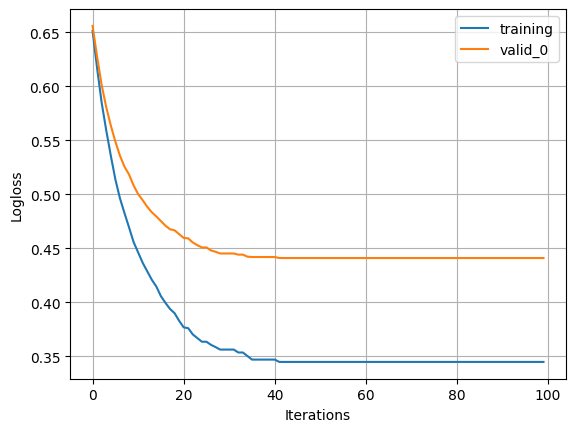

In [148]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='training')
plt.plot(results['validation_1']['logloss'], label='valid_0')
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Logloss")
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
import sklearn.datasets, sklearn.model_selection

X, y = sklearn.datasets.load_boston(return_X_y=True)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, random_state=7054)

model = model = xgb.XGBClassifier(booster='dart', colsample_bytree=0.88, gamma=5, learning_rate=0.1)
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)

xgb.plot_metric(model)

In [ ]:
sns.lineplot(results['validation_0']['logloss'], label='training')
sns.lineplot(results['validation_1']['logloss'], label='valid_0')
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Logloss")
# show the legend
plt.legend()
# show the plot
plt.show()

[10]	training's l2: 0.118409	valid_0's l2: 0.162009
[20]	training's l2: 0.0822388	valid_0's l2: 0.149616
[30]	training's l2: 0.0629611	valid_0's l2: 0.148295
[40]	training's l2: 0.0503186	valid_0's l2: 0.149131
[50]	training's l2: 0.0412906	valid_0's l2: 0.150288
[60]	training's l2: 0.0343408	valid_0's l2: 0.151413
[70]	training's l2: 0.0291906	valid_0's l2: 0.153136
[80]	training's l2: 0.0248597	valid_0's l2: 0.154706
[90]	training's l2: 0.0212619	valid_0's l2: 0.155623
[100]	training's l2: 0.018471	valid_0's l2: 0.156878
[110]	training's l2: 0.016117	valid_0's l2: 0.158112
[120]	training's l2: 0.0140491	valid_0's l2: 0.159031
[130]	training's l2: 0.0122464	valid_0's l2: 0.159853
[140]	training's l2: 0.010774	valid_0's l2: 0.160357
[150]	training's l2: 0.00943668	valid_0's l2: 0.161186
[160]	training's l2: 0.00829919	valid_0's l2: 0.16179
[170]	training's l2: 0.00728342	valid_0's l2: 0.162479
[180]	training's l2: 0.00649452	valid_0's l2: 0.162927
[190]	training's l2: 0.00578987	valid_

<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

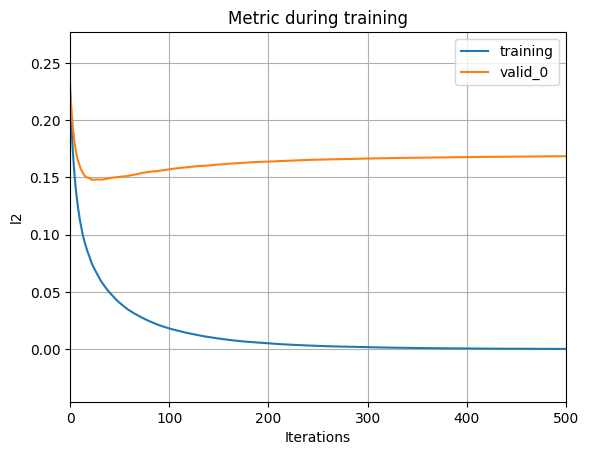

In [149]:
import lightgbm as lgb
import sklearn.datasets, sklearn.model_selection
X, y = sklearn.datasets.load_boston(return_X_y=True)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, random_state=7054)

model = lgb.LGBMRegressor(objective='mse', seed=42, num_threads=1, num_iterations=500)
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)

lgb.plot_metric(model)

In [ ]:
from sklearn.model_selection import validation_curve

In [ ]:
with open('data_FAA/data.pkl', 'wb') as f:
    joblib.dump([X_train, y_train, X_test, y_test], f)

In [ ]:
validation_curve()

In [ ]:
PARAMETERS = {'normalize' : [True, False],
              'positive': [True, False],}

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=RidgeClassifier(),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

xgbr_best = grid_search_xgb.best_estimator_
print("Elastic Net")
print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=10).mean())
# print('xgbr feature importances',grid_search_xgb.feature_importances_)

In [ ]:
perm = PermutationImportance(grid_search_xgb, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
pred = grid_search_xgb.predict(X_test)
print(classification_report(y_test, pred, target_names=["0","1"]))
plot_roc_curve(grid_search_xgb, X_test, y_test)
#Comentário

In [ ]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/test.csv")
data2['Transported'] =-1
dataT = pd.concat([data1,data2],axis = 0,ignore_index=True)

df_T,target = preprocess(dataT,preTrain = False)
X_testT = df_T[df_T['Transported'] ==-1]
X_testT = X_testT.drop(['Transported'],axis = 1)

pred = grid_search_xgb.predict(X_testT)
pred = pred.astype(bool)

result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission.csv', index=False)

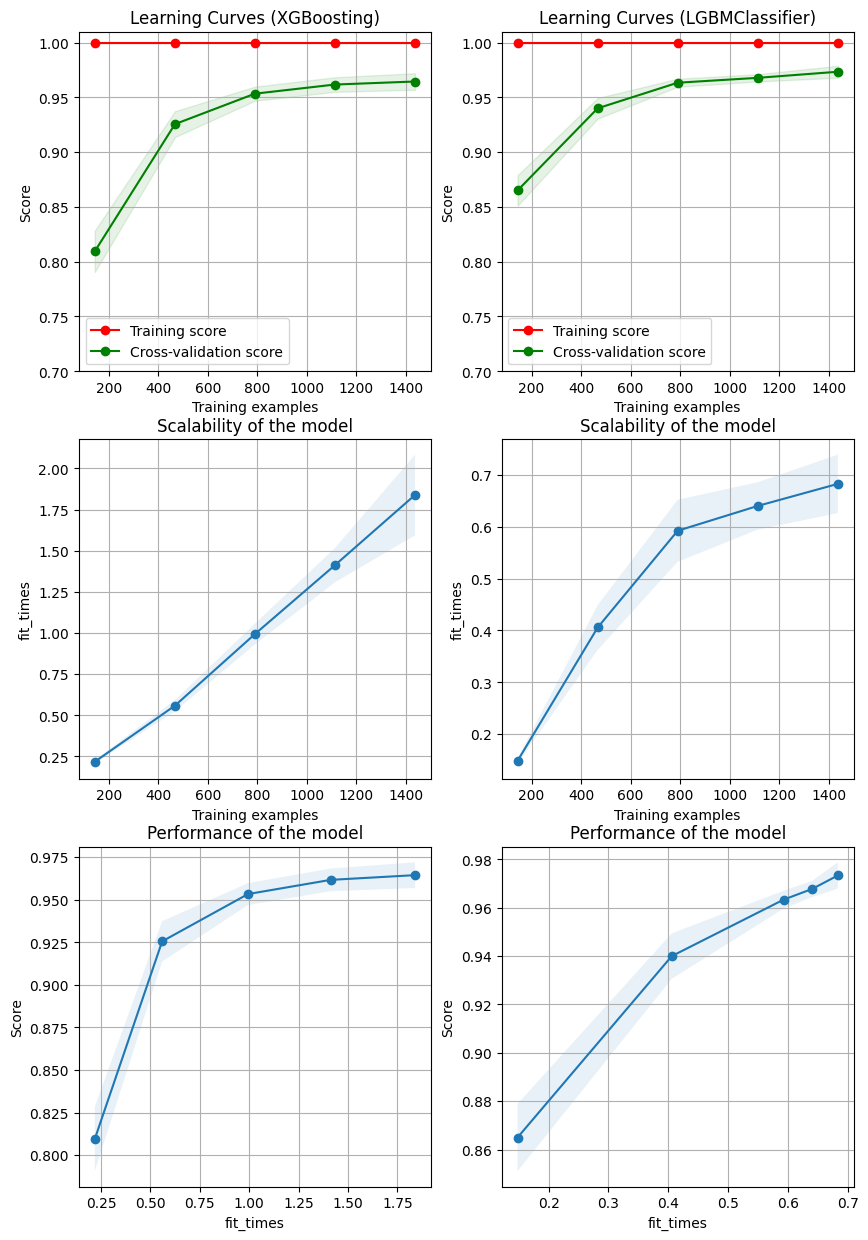

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (XGBoosting)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

estimator = xgb.XGBClassifier()
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="accuracy",
)

title = r"Learning Curves (LGBMClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = lgb.LGBMClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [152]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)
clear_output()

100%|██████████| 29/29 [00:02<00:00, 10.69it/s]


NameError: name 'clear_output' is not defined

In [156]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
CalibratedClassifierCV,0.79,0.79,0.79,0.79,0.26
LGBMClassifier,0.79,0.79,0.79,0.79,0.16
LinearSVC,0.79,0.79,0.79,0.79,0.07
RandomForestClassifier,0.79,0.79,0.79,0.79,0.24
LogisticRegression,0.79,0.79,0.79,0.79,0.02
ExtraTreesClassifier,0.79,0.79,0.79,0.79,0.22
NuSVC,0.78,0.78,0.78,0.78,0.31
SVC,0.78,0.78,0.78,0.78,0.33
XGBClassifier,0.78,0.78,0.78,0.78,0.12


In [160]:
import plotly.express as px

In [161]:
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()